Este es mi modelado para poner mi satelite en orbita

In [140]:
## primero las reduced order ecuations

G = 6.67430e-11  # constante de gravitación universal (m^3 kg^-1 s^-2)
M_earth = 5.972e24  # masa de la Tierra (kg)

r = 0  #desplazamiento radial (m)
q = 0  # velocidad radial (m/s)
r_dot = q  # velocidad radial (m/s)
q_dot = 0  # aceleracion radial (m/s^2)

theta = 0  # desplazamiento angular (rad)
gamma = 0  # velocidad angular (rad/s)
theta_dot = gamma # velocidad angular (rad/s)
gamma_dot = 0  # aceleracion angular (rad/s^2)

In [141]:
import numpy as np
import math

G = 6.67430e-11      # m^3/kg/s^2 (gravitational constant)
M_earth = 5.972e24   # kg
R_E = 6.371e6         # m
ITERACIONES = 1000000 # numero de iteraciones
Cd = 0.47             # coeficiente de arrastre (drag coefficient) de una esfera
alturaLeo = 2e5  # m

In [142]:
def calcDensidadAire(altura):
    if altura < 11000:
        T = 15.04 - 0.00649 * altura # temperatura en °C y altura en m
        P = 101.29 * ((T + 273.1) / 288.08) ** 5.256 # presión en kPa
    elif 11000 <= altura < 25000:
        T = -56.46 # temperatura en °C
        P = 22.65 * math.exp(1.73 - 0.000157 * altura) # presión en kPa
    else:
        T = -131.21 + 0.00299 * altura # temperatura en °C
        P = 2.488 * ((T + 273.1) / 216.6) ** -11.388 # presión en kPa
    rho = P / (0.2869 * (T + 273.1)) # densidad en kg/m^3
    return rho

def calcGravedad(altura):
    """ Calcula la gravedad en función de la altura sobre la superficie terrestre."""
    return G * M_earth / (R_E + altura) ** 2


def calcVelocidad(v_rad, v_ang, distancia_radial):
    """ Calcula la velocidad total a partir de las componentes radial y angular."""
    return math.sqrt(v_rad**2 + (v_ang * distancia_radial)**2)

def calcAreaFrontalEsfera(radio):
    """ Calcula el área de una esfera dado su radio."""
    return math.pi * radio**2

def calcBeta(tiempoDeVuelo):
    """ Calcula el ángulo de inclinación del empuje en función del tiempo de vuelo."""
    if tiempoDeVuelo < 10:
        return 0
    elif 10 <= tiempoDeVuelo < 100:
        #print("Tiempo de vuelo entre 10 y 100 segundos, beta entre 0 y 45 grados" + str((math.pi / 4) * (tiempoDeVuelo - 10) / 90))
        ## cambiamos hasta 45 grados gradualmente
        return (math.pi / 4) * (tiempoDeVuelo - 10) / 90
    else:
        #print("Tiempo de vuelo mayor a 100 segundos, beta entre 45 y 90 grados")
        ## ahora cambiamos a 90 grados gradualmente
        return (math.pi / 4) + (math.pi / 4) * (tiempoDeVuelo - 100) / 100

In [143]:
class cohete:
    def __init__(self, r_0 = R_E, q_0 = 0, q_dot_0 = 0, theta_0 = 0, gamma_0 = 0, gamma_dot_0 = 0, masa_cohete = 20000, masa_fuel = 20000 , beta = 0, diametro = 4, m_dot = 0, isp = 300):
        self.r = r_0 # desplazamiento radial (m)
        self.q = q_0 # velocidad radial (m/s)
        self.q_dot = q_dot_0 # aceleración radial (m/s^2)
        self.theta = theta_0 # desplazamiento ángular (rad)
        self.gamma = gamma_0 # velocidad angular (rad/s)
        self.gamma_dot = gamma_dot_0 # aceleracion angular (rad/s^2)
        self.masa = masa_cohete + masa_fuel # masa del cohete (kg)
        self.masa_cohete = masa_cohete # masa del cohete sin fuel (kg)
        self.beta = beta # angulo de inclinación del empuje (rad)
        self.diametro = diametro # diametro del cohete (m)
        self.m_dot = m_dot # tasa de consumo de masa (kg/s)
        self.isp = isp # impulso especifico (s) y constante

        # valores historicos
        self.r_hist = [r_0]
        self.q_hist = [q_0]
        self.q_dot_hist = [q_dot_0]
        self.theta_hist = [theta_0]
        self.gamma_hist = [gamma_0]
        self.gamma_dot_hist = [gamma_dot_0]
        self.masa_hist = [masa_cohete + masa_fuel]
        self.beta_hist = [beta]

    def forward_euler(self, dt):
        """esto devuelve (desplazamiento radial, velocidad radial, desplazamiento angular, velocidad angular) """
        self.beta = calcBeta(dt * len(self.r_hist))  # actualizamos beta en función del tiempo de vuelo
        #print(f"Beta actualizado a {self.beta} radianes")
        #print(f"largo de r_hist: {len(self.r_hist)}")
        self.r = self.q * dt + self.r
        self.q = (self.r * (self.gamma ** 2) - (G * M_earth / self.r ** 2)) * dt + self.q
        self.gamma = -(2 * self.q * self.gamma / self.r) * dt + self.gamma
        self.theta = self.gamma * dt + self.theta
        self.q_dot = (- calcGravedad(self.r + R_E)) - Cd * 1/2 * calcDensidadAire(self.r + R_E) * calcVelocidad(self.q, self.gamma, self.r + R_E) * self.q * calcAreaFrontalEsfera(self.diametro / 2) + self.isp * self.m_dot * calcGravedad(self.r + R_E) * math.cos(self.beta) + self.r * (self.gamma ** 2)
        self.gamma_dot = (- Cd * 1/2 * calcDensidadAire(self.r + R_E) * calcVelocidad(self.q, self.gamma, self.r + R_E) * calcAreaFrontalEsfera(self.diametro / 2) * self.r * self.gamma + self.isp * self.m_dot * calcGravedad(self.r + R_E) * math.sin(self.beta) - (2 * self.q * self.gamma)) / self.r

        return (self.r, self.q, self.theta, self.gamma)


    def simular(self, dt):
        print(f"Simulando el cohete con dt = {dt}")
        iter = 0
        while self.r >= R_E and iter < ITERACIONES and self.masa > self.masa_cohete:
            #print(f"Iteracion {iter}: r = {self.r}, q = {self.q}, theta = {self.theta}, gamma = {self.gamma}, masa = {self.masa}, q_dot = {self.q_dot}, gamma_dot = {self.gamma_dot}, beta = {self.beta}")
             # actualizar los historicos
            if len(self.r_hist) > 5000:
                print("el beta actual es: " + str(self.beta))
            res = self.forward_euler(dt)
            self.r_hist.append(res[0])
            self.q_hist.append(res[1])
            self.theta_hist.append(res[2])
            self.gamma_hist.append(res[3])
            self.q_dot_hist.append(self.q_dot)
            self.gamma_dot_hist.append(self.gamma_dot)
            self.masa -= self.m_dot * dt
            self.masa_hist.append(self.masa)
            self.beta_hist.append(self.beta)
            iter += 1
        print(f"El cohete ha caido a la Tierra despues de {iter} iteraciones")
        return


In [144]:

velocidadInicial = 10000 # m/s 
## luego descomponemos esta v inicial en sus cordenadas polares correspondientes
cohete1 = cohete(
    r_0= R_E,
    q_0 = math.cos((math.pi / 4)) * velocidadInicial,
    q_dot_0=0,
    theta_0=0,
    gamma_0=0,  ## (math.sin((math.pi / 4)) * velocidadInicial) / R_E,
    gamma_dot_0=0,
    masa_cohete=20000,
    masa_fuel=200000,
    beta= 0,
    diametro=4,
    m_dot=50,
    isp=300
)

cohete1.simular(0.1)

## verificamos si los valores tienen sentido
print(f"Altura maxima alcanzada: {(max(cohete1.r_hist) - R_E) / 1000} km")
print(f"Velocidad maxima alcanzada: {max(cohete1.q_hist)} m/s")
print(f"Velocidad angular maxima alcanzada: {max(cohete1.gamma_hist)} rad/s")
print(f"Tiempo total de vuelo: {len(cohete1.r_hist)} segundos")
print(f"Tiempo total de vuelo: {len(cohete1.r_hist) / 60} minutos")
## distancia entre punto inicial y punto final (desplazamiento que describe el arco)
## aca hay que calcular la distancia recorrida sobre la superficie de la tierra (el arco formado por radio de la tierra)

desplazamiento_angular_total = cohete1.theta_hist[-1] - cohete1.theta_hist[0]
print("Desplazamiento angular total (rad):")
print(desplazamiento_angular_total)


distancia = R_E * desplazamiento_angular_total # en metros
print(f"Distancia entre punto inicial y punto final (usando arco): {distancia / 1000} km")

## Distancia entre punto inicial y punto final (usando arco): 0.6194182149249586 km usando delta = 1

Simulando el cohete con dt = 0.1
el beta actual es: 3.9269908169872414
el beta actual es: 3.927776215150639
el beta actual es: 3.928561613314036
el beta actual es: 3.9293470114774336
el beta actual es: 3.930132409640831
el beta actual es: 3.930917807804229
el beta actual es: 3.9317032059676262
el beta actual es: 3.932488604131024
el beta actual es: 3.933274002294421
el beta actual es: 3.934059400457819
el beta actual es: 3.934844798621216
el beta actual es: 3.9356301967846137
el beta actual es: 3.936415594948011
el beta actual es: 3.9372009931114085
el beta actual es: 3.937986391274806
el beta actual es: 3.9387717894382033
el beta actual es: 3.9395571876016007
el beta actual es: 3.940342585764998
el beta actual es: 3.9411279839283955
el beta actual es: 3.941913382091793
el beta actual es: 3.9426987802551903
el beta actual es: 3.9434841784185877
el beta actual es: 3.944269576581986
el beta actual es: 3.945054974745383
el beta actual es: 3.9458403729087808
el beta actual es: 3.9466257710

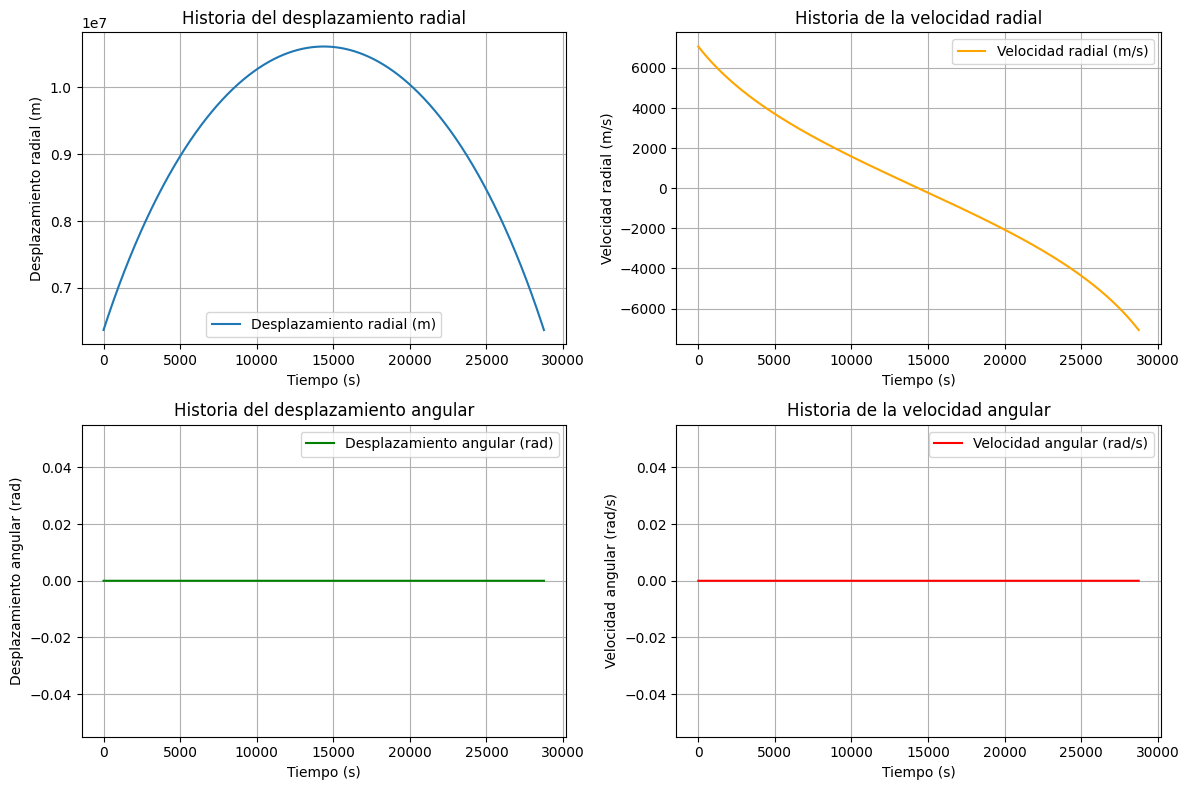

In [145]:
## graficamos los datos historicos del cohete

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(cohete1.r_hist, label='Desplazamiento radial (m)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Desplazamiento radial (m)')
plt.title('Historia del desplazamiento radial')
plt.grid()
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(cohete1.q_hist, label='Velocidad radial (m/s)', color='orange')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad radial (m/s)')
plt.title('Historia de la velocidad radial')
plt.grid()
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(cohete1.theta_hist, label='Desplazamiento angular (rad)', color='green')
plt.xlabel('Tiempo (s)')
plt.ylabel('Desplazamiento angular (rad)')
plt.title('Historia del desplazamiento angular')
plt.grid()
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(cohete1.gamma_hist, label='Velocidad angular (rad/s)', color='red')
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad angular (rad/s)')
plt.title('Historia de la velocidad angular')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()





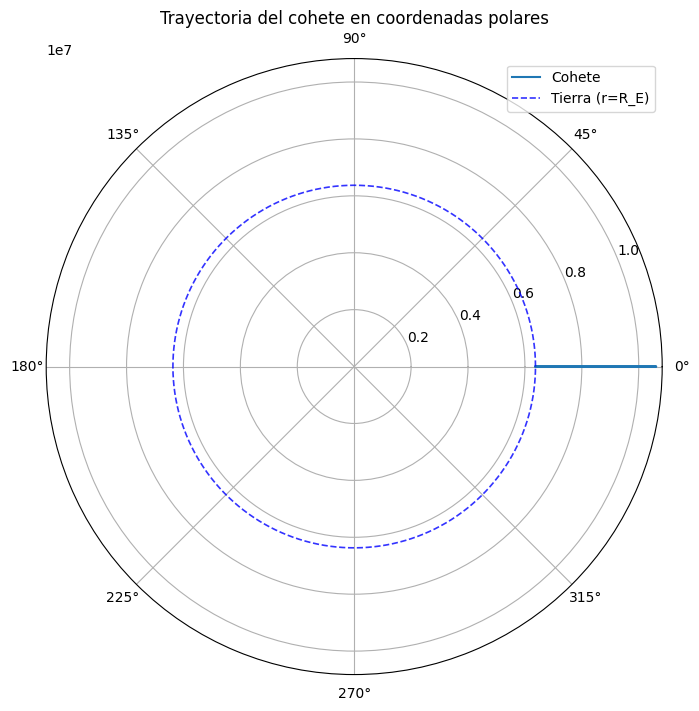

In [146]:
## graficar el desplazamiento en un plano polar y agrego la circunferencia de la tierra
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')
ax.plot(cohete1.theta_hist, cohete1.r_hist, label='Cohete')  # tu curva original

# >>> Circunferencia de la Tierra (misma unidad que r_hist: si r está en metros, R_E en metros)
import numpy as np
theta = np.linspace(0, 2*np.pi, 720)
ax.plot(theta, np.full_like(theta, R_E), 'b--', lw=1.2, alpha=0.8, label='Tierra (r=R_E)')

ax.set_title("Trayectoria del cohete en coordenadas polares")
ax.legend(loc='upper right')
plt.show()


